# Collaboration and Competition Solution

---

This notebook contains my solution to the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

Begin by importing the necessary packages and starting the tennis environment.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import random
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import namedtuple, deque
from udacity_model import Actor, Critic
from udacity_replay_buffer import ReplayBuffer, ActionNoise
from udacity_agent import Agent

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
observations = env_info.vector_observations
observation_size = observations.shape[1]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### 2. Train the Agent

The play_tennis() fuction trains one agent with two actors to act in the environment using MADDPG.

In [2]:
agent = Agent(num_agents, observation_size, action_size, 7654321)

def play_tennis(n_episodes=5000, print_every=100, EPS=1.0, eps_decay=0.9985, eps_floor=0.05):
    
    # Keep track of scores over episodes
    scores_window = deque(maxlen=print_every)
    training_scores = []
    
    for i_episode in range(1, n_episodes+1):
        
        # Gen environment info
        env_info = env.reset(train_mode=True)[brain_name]
        observations = env_info.vector_observations
        
        # Keep track of score within episode
        episode_scores = np.zeros(num_agents)
        
        while True:
            
            # Act, step through env and record states
            actions = agent.act(observations, EPS)
            env_info = env.step(actions)[brain_name]
            next_observations = env_info.vector_observations
            
            rewards = env_info.rewards
            dones = env_info.local_done
            
            # Agent steps and trains
            agent.step(observations, actions, rewards, next_observations, dones)
            
            # Update state, accumulate reward, break if done
            observations = next_observations
            episode_scores += rewards
            if np.any(dones):
                break
        
        # Add scores to lists
        scores_window.append(max(episode_scores))
        training_scores.append(max(episode_scores))
        
        # Update epsilon
        EPS = max(EPS*eps_decay,eps_floor)
        
        print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_window)))
            
        if np.mean(scores_window)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode-100, np.mean(scores_window)))
            break
        
    return training_scores

scores = play_tennis()
env.close()

Episode 100	Average Score: 0.021
Episode 200	Average Score: 0.015
Episode 300	Average Score: 0.010
Episode 400	Average Score: 0.007
Episode 500	Average Score: 0.005
Episode 600	Average Score: 0.003
Episode 700	Average Score: 0.001
Episode 800	Average Score: 0.000
Episode 900	Average Score: 0.002
Episode 1000	Average Score: 0.002
Episode 1100	Average Score: 0.000
Episode 1200	Average Score: 0.005
Episode 1300	Average Score: 0.013
Episode 1400	Average Score: 0.021
Episode 1500	Average Score: 0.016
Episode 1600	Average Score: 0.037
Episode 1700	Average Score: 0.049
Episode 1800	Average Score: 0.046
Episode 1900	Average Score: 0.052
Episode 2000	Average Score: 0.055
Episode 2100	Average Score: 0.048
Episode 2200	Average Score: 0.054
Episode 2300	Average Score: 0.047
Episode 2400	Average Score: 0.039
Episode 2500	Average Score: 0.043
Episode 2600	Average Score: 0.047
Episode 2700	Average Score: 0.047
Episode 2800	Average Score: 0.045
Episode 2900	Average Score: 0.045
Episode 3000	Average Sc

In [4]:
# Save the successful model weights
torch.save(agent.actors_local[0].state_dict(), 'actor0_local.pth')
torch.save(agent.critics_local[0].state_dict(), 'critic0_local.pth')
torch.save(agent.actors_local[1].state_dict(), 'actor1_local.pth')
torch.save(agent.critics_local[1].state_dict(), 'critic1_local.pth')

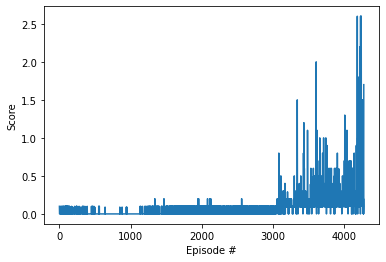

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()